# A/B Testing 

## Practicum 100 

## Final Project. Part 2

### by Vadim Fridman

#### Step 0. Intro & Table of content

<a class="anchor" id="introduction"></a>


We are working as a junior Data Analyst. We received an analytical task from an international online store. Our predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results. 

We are going to make the job fully done: first of all to check if the performance(better conversion) of the group B(new payment funnel)  is better then in the control group(A).

"Better conversion" means here at least 10% increase  on the all stages. 

It's expected, that at least 6000 the paricipants of the study will be 15% of new users from the EU region that signed up between the 7th and 21st December 2020. 

#### Table of contents

0. [Step 0: Intro & Table of content](#introduction)


1. [Step 1.  Download & Check data](#part1)


2. [Step 2. EDA ](#part2)
    - [Step 2.1 Data preprocessing](#part21)
    
    - [Step 2.2 Conversion](#part22)
    
    - [Step 2.3 Number of events per user in the samples](#part23)
    
    - [Step 2.4 Are there users who enter both samples?](#part24)  
    
    - [Step 2.5 How is the number of events distributed by days?](#part25)
    
    - [Step 2.6 Before the A/B test](#part26) 
    
    
3. [Step 3. Step 3. A/B Test Evaluation](#part3)


4. [Step 4. Overall conclusion](#conclusion)


#### Step 1. Download & Convert datatypes

<a class="anchor" id="part1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import ticker
import scipy.stats as stats
import pylab as plt
#import seaborn as sns
#import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import scipy.stats as st
from statsmodels.stats import weightstats as stests
import math

import warnings
warnings.filterwarnings('ignore')

Let's have a first look on the datasets we have and convert the datatypes where it is reasonable. 

In [2]:
try:
    final_events = pd.read_csv('final_ab_events_upd_us.csv', dtype={'event_name': 'category'}, parse_dates=["event_dt"])
except:
    final_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', dtype={'event_name': 'category'}, parse_dates=["event_dt"])
final_events.sample(20)

,user_id,event_dt,event_name,details
58464,7F4AE5E862EAA269,2020-12-28 03:34:13,purchase,99.99
212986,661B2C9A8A14C01C,2020-12-22 06:32:08,product_page,NaN
162974,EEB80BCBD65AC289,2020-12-15 09:32:41,product_page,NaN
407182,6D97F3841A5E9025,2020-12-26 08:45:58,login,NaN
226180,C1C2130BEFEBC63D,2020-12-24 17:59:18,product_page,NaN
326917,D7AF35AD08C12EFB,2020-12-18 23:44:52,login,NaN
279411,CC17913DD4643380,2020-12-13 09:58:29,login,NaN
168852,F5D1301FD4CA4BAE,2020-12-16 02:28:10,product_page,NaN
275014,9F64ECA437B4E3A8,2020-12-12 02:41:30,login,NaN
18472,29D1CF72F700895D,2020-12-15 14:23:24,purchase,4.99


In [3]:
final_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
user_id       423761 non-null object
event_dt      423761 non-null datetime64[ns]
event_name    423761 non-null category
details       60314 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.1+ MB


In [4]:
final_events.user_id.nunique()

58703

So we have here timestamps of the events were registered in the shop's system (_*login, product_page, product_cart, purchase*_). Some of events (all of purchases?) also has revenue information in the 'detail column. 

We have more than 423K rows of data/events of 58K unique users in the dataset.

We also have a lot of missing values in the _*details*_ column. It's okay since in the column was saved additional information, and only a one part of the events(presumably, purchases only) have this extra details. 

We are going to replace NaN's by zeros so we can work with numerical values in this column. 

In [5]:
final_events.details = final_events.details.replace(np.nan, 0)

In [6]:
final_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
user_id       423761 non-null object
event_dt      423761 non-null datetime64[ns]
event_name    423761 non-null category
details       423761 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.1+ MB


In [7]:
final_events.duplicated().sum()

0

We have no explicit duplicates in the dataset. It's pretty good. 

In [8]:
try:
    users = pd.read_csv('final_ab_new_users_upd_us.csv', dtype={'device': 'category', 'region': 'category'}, parse_dates=["first_date"])
except:
    users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', dtype={'device': 'category', 'region': 'category'}, parse_dates=["first_date"])
users.sample(10)

,user_id,first_date,region,device
42294,D70FACED71CA11C1,2020-12-18,EU,PC
31792,777D6C423998928D,2020-12-23,N.America,Android
35537,61A60C03BECDA6E2,2020-12-17,EU,Android
52849,1FE8F8E1FEE9A2F4,2020-12-13,EU,PC
29105,A5D8C583CD59B97A,2020-12-16,EU,Android
40214,010DF73DACCC1534,2020-12-18,EU,Android
47157,65A0580D60F87103,2020-12-19,EU,Android
52982,A2C0C4C4D7A73410,2020-12-13,EU,PC
36901,BB174FD896B22591,2020-12-17,EU,iPhone
49446,850C81FE7FD7EB35,2020-12-19,N.America,Android


In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
user_id       58703 non-null object
first_date    58703 non-null datetime64[ns]
region        58703 non-null category
device        58703 non-null category
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.0+ MB


Here we have registration date, region and device information. No missing values!  

In [10]:
users.region.nunique()

4

In [11]:
users.device.nunique()

4

In [12]:
users.duplicated().sum()

0

We just checked by the way, if the data in the two last columns are categorical & that we have explicit duplicates in the dataset. 

In [13]:
try:
    participants = pd.read_csv('final_ab_participants_upd_us.csv', dtype={'group': 'category', 'ab_test': 'category'})
except:
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv', dtype={'group': 'category', 'ab_test': 'category'})
participants.sample(10)

,user_id,group,ab_test
9932,A800CDEA85871EEF,B,interface_eu_test
2356,AAEE1D820ABE40A8,A,recommender_system_test
12739,DE0CA758640763A8,B,interface_eu_test
4750,D05B44F29BB257D8,B,interface_eu_test
5283,DC2FFF13CFB28EAC,A,interface_eu_test
14043,5680B8B382F56926,B,interface_eu_test
10996,9CBB0870AEA0C7BF,A,interface_eu_test
789,EAA6967BB9807DF2,A,recommender_system_test
477,D902807C00F2AF2D,A,recommender_system_test
8047,0F50B14D0B2FA84A,B,interface_eu_test


In [14]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
user_id    14525 non-null object
group      14525 non-null category
ab_test    14525 non-null category
dtypes: category(2), object(1)
memory usage: 142.1+ KB


In [15]:
participants.user_id.nunique()

13638

In [16]:
participants.ab_test.nunique()

2

In [17]:
participants.group.nunique()

2

Only 13k from 58K of all user are participants of the test. 

It seems, that we have some duplicates in the dataset. 

In [18]:
participants[participants['user_id'].duplicated()].head(20)

,user_id,group,ab_test
3677,FB6F6BC119E1DBD5,B,interface_eu_test
3688,055A4CD17A483B8E,A,interface_eu_test
3695,7060BB1CBE3BAACC,B,interface_eu_test
3711,8A26EBC1BA92524B,B,interface_eu_test
3730,A791C2D62B213C96,B,interface_eu_test
3774,F13CC3EF6739F4C0,B,interface_eu_test
3777,C7D588F1ABF3A91B,A,interface_eu_test
3797,D857FFFE7A6AC9A4,A,interface_eu_test
3819,D0562837FBB58AC5,B,interface_eu_test
3834,6786C23A54D59DD4,A,interface_eu_test


In [19]:
len(participants[participants['user_id'].duplicated()])

887

Assumably we have 887 duplicates. Les's look into a bit closer on some examples. 

In [20]:
participants[participants['user_id']=='FB6F6BC119E1DBD5']

,user_id,group,ab_test
2397,FB6F6BC119E1DBD5,A,recommender_system_test
3677,FB6F6BC119E1DBD5,B,interface_eu_test


In [21]:
participants[participants['user_id']=='7060BB1CBE3BAACC']

,user_id,group,ab_test
551,7060BB1CBE3BAACC,B,recommender_system_test
3695,7060BB1CBE3BAACC,B,interface_eu_test


In [22]:
participants[participants['user_id']=='055A4CD17A483B8E']

,user_id,group,ab_test
2742,055A4CD17A483B8E,A,recommender_system_test
3688,055A4CD17A483B8E,A,interface_eu_test


It seems that some users participate in the both groups and/or tests. The first looks at least strange. We don't really know, why this data is corrupted. But we know exactly, that this information can not be true. 

Probably we should get rid of this data since it's incorrect. 

In [23]:
participants=participants[participants['user_id'].duplicated()==False]

In [24]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13638 entries, 0 to 14524
Data columns (total 3 columns):
user_id    13638 non-null object
group      13638 non-null category
ab_test    13638 non-null category
dtypes: category(2), object(1)
memory usage: 239.8+ KB


In [25]:
len(participants[participants['user_id'].duplicated()])

0

We got 13638 rows - exactly one for each unique user. 

In [26]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events_us.csv', parse_dates=["start_dt", "finish_dt"])
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates=["start_dt", "finish_dt"])
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [27]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [28]:
marketing_events.regions.nunique()

6

The dataset is really tiny: we can see all the data in the output. It seems, that we don't really need this data to complete the project. 

#### Step 2. EDA

<a class="anchor" id="part2"></a>

##### Step 2.1 Data preprocessing

<a class="anchor" id="part21"></a>

Before we go any further we are going to look a bit closer on the datasets we have and check if we can trust our data. 

In [29]:
final_events.shape

(423761, 4)

In [30]:
final_events.tail()

,user_id,event_dt,event_name,details
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.0
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.0
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.0
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.0
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,0.0


In [31]:
(final_events.details < 0).sum()

0

We have nor orders with negative price. It's good sign. 

In [32]:
final_events.event_dt.min()

Timestamp('2020-12-07 00:00:33')

In [33]:
final_events.event_dt.max()

Timestamp('2020-12-30 23:36:33')

In [34]:
users.first_date.min()

Timestamp('2020-12-07 00:00:00')

In [35]:
users.first_date.max()

Timestamp('2020-12-23 00:00:00')

In [36]:
marketing_events.start_dt.min()

Timestamp('2020-01-25 00:00:00')

In [37]:
marketing_events.start_dt.max()

Timestamp('2020-12-30 00:00:00')

In [38]:
marketing_events.finish_dt.min()

Timestamp('2020-02-07 00:00:00')

In [39]:
marketing_events.finish_dt.max()

Timestamp('2021-01-07 00:00:00')

The data looks good: we are dealing with (almost) the same time period in _*users*_ and _*final_events*_ datasets. It's 100% plausible that users were signed up first and after that they took part in the some events. 

In the _*marketing_events*_ dataset dates are also believable: start dates are before final dates; we have data for the whole 2020 and even the start of 2021, that corresponds with our marketing datasets. 

We are going to check the test data we have. We saw in the previous step, we have data of two different tests. 

At first we merge test data (_*participants*_ dataset)  with _*final_events*_ dataset: otherwise we can not really work with the 1st one since it is not really informative. 

In [40]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13638 entries, 0 to 14524
Data columns (total 3 columns):
user_id    13638 non-null object
group      13638 non-null category
ab_test    13638 non-null category
dtypes: category(2), object(1)
memory usage: 239.8+ KB


In [41]:
final_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
user_id       423761 non-null object
event_dt      423761 non-null datetime64[ns]
event_name    423761 non-null category
details       423761 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.1+ MB


In [42]:
df = final_events.merge(participants, on='user_id')

In [43]:
df.sample(5)

,user_id,event_dt,event_name,details,group,ab_test
26926,3F930D9D6D1F1262,2020-12-17 11:34:58,login,0.0,A,interface_eu_test
89235,06C45950CF7E4B2E,2020-12-28 17:17:55,product_page,0.0,B,interface_eu_test
95023,D9715C63505DA68F,2020-12-20 17:07:44,login,0.0,A,interface_eu_test
66769,4D2F97258975A026,2020-12-09 18:52:49,login,0.0,A,interface_eu_test
85521,42C60981E2D02234,2020-12-24 02:34:50,product_page,0.0,B,interface_eu_test


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97123 entries, 0 to 97122
Data columns (total 6 columns):
user_id       97123 non-null object
event_dt      97123 non-null datetime64[ns]
event_name    97123 non-null category
details       97123 non-null float64
group         97123 non-null category
ab_test       97123 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 3.2+ MB


In [45]:
df.user_id.nunique()

13638

So we have now a dataset with 97123 rows of event data of 13638 unique test participants only. 

Let's have a closer look on the tests data.

In [46]:
eu_test = df[df['ab_test'] == 'interface_eu_test']
eu_test.user_id.nunique()

9963

In [47]:
rst = df[df['ab_test'] == 'recommender_system_test']
rst.user_id.nunique()

3675

At this point we have to notice, that the data of 'recommender_system_test' does not meet the test's requirements (we need at least 6000 participants, we have less than 4000). 

Let's check, if the 2nd test data meets the other requirements. 

In [48]:
eu_test.sample()

,user_id,event_dt,event_name,details,group,ab_test
28383,FAFF30D9DB812AC4,2020-12-21 07:46:14,product_cart,0.0,B,interface_eu_test


In [49]:
eu_test = eu_test.merge(users, on = "user_id")

In [50]:
eu_test.sample(10)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
23806,9AA3EE102047947D,2020-12-20 23:56:10,purchase,499.99,B,interface_eu_test,2020-12-19,EU,Android
35771,1E63518899831413,2020-12-10 14:13:20,product_page,0.00,A,interface_eu_test,2020-12-09,EU,iPhone
27853,7CCCC6057ADD3A46,2020-12-23 11:08:03,login,0.00,B,interface_eu_test,2020-12-21,EU,Android
44701,9FA5B0E128A57229,2020-12-18 16:11:47,product_cart,0.00,B,interface_eu_test,2020-12-17,EU,Mac
67850,7C821E010A225D28,2020-12-27 18:42:48,login,0.00,A,interface_eu_test,2020-12-22,EU,Mac
44917,FD2CFB46A7C73C63,2020-12-23 17:33:45,product_page,0.00,B,interface_eu_test,2020-12-17,EU,PC
41271,8FBA32D5208B685A,2020-12-14 03:14:39,product_page,0.00,A,interface_eu_test,2020-12-14,EU,iPhone
23853,2E6D5E5DD865146C,2020-12-21 06:38:48,product_page,0.00,A,interface_eu_test,2020-12-19,EU,iPhone
37008,E64A29E168C91D92,2020-12-10 07:45:14,product_page,0.00,B,interface_eu_test,2020-12-10,EU,Mac
7434,2A95B8EEF2C290DA,2020-12-22 05:46:29,purchase,4.99,B,interface_eu_test,2020-12-10,EU,Android


In [51]:
eu_test.user_id.nunique()

9963

In [52]:
eu_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73214 entries, 0 to 73213
Data columns (total 9 columns):
user_id       73214 non-null object
event_dt      73214 non-null datetime64[ns]
event_name    73214 non-null category
details       73214 non-null float64
group         73214 non-null category
ab_test       73214 non-null category
first_date    73214 non-null datetime64[ns]
region        73214 non-null category
device        73214 non-null category
dtypes: category(5), datetime64[ns](2), float64(1), object(1)
memory usage: 3.1+ MB


In [53]:
eu_test.region.nunique()

1

It's not very surprising, that in the 'eu_test' participate users from EU only. But it does not meet one of our test's requirements("Audience: 15% of the new users from the EU region"). 

Maybe we have to use 'recommender_system_test' data? Let's check the geographic there. 

In [54]:
rst = rst.merge(users, on = "user_id")

In [55]:
rst.region.nunique()

4

In [56]:
rst.region.unique()

[EU, N.America, CIS, APAC]
Categories (4, object): [EU, N.America, CIS, APAC]

In [57]:
rst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23909 entries, 0 to 23908
Data columns (total 9 columns):
user_id       23909 non-null object
event_dt      23909 non-null datetime64[ns]
event_name    23909 non-null category
details       23909 non-null float64
group         23909 non-null category
ab_test       23909 non-null category
first_date    23909 non-null datetime64[ns]
region        23909 non-null category
device        23909 non-null category
dtypes: category(5), datetime64[ns](2), float64(1), object(1)
memory usage: 1.0+ MB


In [58]:
rst_u = rst[['user_id','region']].drop_duplicates()
len(rst_u)

3675

In [59]:
len(rst_u[rst_u['region']=='EU']) / len(rst_u)

0.9472108843537415

Almost all (95%) of the 'recommender_system_test' participants were from EU. It does not meet the reqirements either. 

In [60]:
len(rst[rst['group']=='A']) / len(rst)

0.779079007904973

In [61]:
len(rst[rst['group']=='B']) / len(rst)

0.22092099209502697

Partition into groups during 'recommender_system_test' was performed very strange with ratio 78% to 22%. It seems, that the test was not performed correctly or data was not collected correctly and it makes this data unusable for our further processing. 

Let's check the other test's group partition. 

In [62]:
len(eu_test[eu_test['group']=='A']) / len(eu_test)

0.5072117354604311

In [63]:
len(eu_test[eu_test['group']=='B']) / len(eu_test)

0.4927882645395689

It looks much better. It seems, that data can be used for statistical tests later. 

##################################################################################################

##### Step 2.2 Conversion

<a class="anchor" id="part22"></a>

We can go for the conversion at different funnel stages now. We need data, how many logins we had, how many of users visited product page, added something to the cart and purchased something. 

In [64]:
by_events = pd.pivot_table(eu_test, index = ['event_name'], values =['event_dt'], aggfunc=['nunique'])
by_events

nunique           
             event_dt event_name
event_name                      
product_cart    10422          1
product_page    20534          1
purchase        10785          1
login           30978          1

In [65]:
by_events.columns = by_events.columns.droplevel(0)

In [66]:
del by_events['event_name']

In [67]:
by_events.columns = ['count']

In [68]:
by_events = by_events.sort_values(by='count', ascending = False)
by_events.reset_index()

,event_name,count
0,login,30978
1,product_page,20534
2,purchase,10785
3,product_cart,10422


Here we can already see the funnel. 

The funnel for has not typical form: the number of orders is bigger, then the number of placing of product to a cart. 

Probably part of the users got a direct link for purchase without using a cart (or they possibly used a "Buy in one click" button). 

In [69]:
event_users = eu_test.groupby('event_name')['user_id'].nunique().sort_values(ascending=False) 
event_users = event_users.reset_index()
event_users.columns = ['event_name', 'nuser_unique']
event_users['ratio'] = (event_users['nuser_unique'] / eu_test.user_id.nunique()) * 100

In [70]:
event_users

,event_name,nuser_unique,ratio
0,login,9962,99.989963
1,product_page,6620,66.445850
2,purchase,3435,34.477567
3,product_cart,3315,33.273111


If we filter users who skip the cart stage, we will probably get classical funnel _*login -> product_page -> product_cart -> purchase.*_ But our tutor says,  such filtration would be redundant. 

##### Step 2.3 Number of events per user in the samples

<a class="anchor" id="part23"></a>

We are assuming, that under "samples" are meant test groups here. 

In [71]:
eu_test_A = eu_test[eu_test['group']=='A']
len(eu_test_A)

37135

In [72]:
eu_test_B = eu_test[eu_test['group']=='B']
len(eu_test_B)

36079

In [73]:
event_users_A = eu_test_A.groupby('event_name')['user_id'].nunique().sort_values(ascending=False) 
event_users_A = event_users_A.reset_index()
event_users_A.columns = ['event_name', 'nuser_unique']
event_users_A['ratio'] = (event_users_A['nuser_unique'] / eu_test_A.user_id.nunique()) * 100

In [74]:
event_users_A

,event_name,nuser_unique,ratio
0,login,5010,99.980044
1,product_page,3366,67.172221
2,purchase,1782,35.561764
3,product_cart,1629,32.508481


In [75]:
event_users_B = eu_test_B.groupby('event_name')['user_id'].nunique().sort_values(ascending=False) 
event_users_B = event_users_B.reset_index()
event_users_B.columns = ['event_name', 'nuser_unique']
event_users_B['ratio'] = (event_users_B['nuser_unique'] / eu_test_B.user_id.nunique()) * 100

In [76]:
event_users_B

,event_name,nuser_unique,ratio
0,login,4952,100.000000
1,product_page,3254,65.710824
2,product_cart,1686,34.046850
3,purchase,1653,33.380452


The calculation data above let us to make a couple of conclusions. 

1st of all, it does not seem, that the group B has any significantly better figures. 

2nd of all, while the funnel for the group B looks absolutly "normal" ( _*login -> product_page -> product_cart -> purchase.*_), the funnel for the group A has not typical form we mentioned above: the number of orders is bigger, then the number of placing of product to a cart. 

Probably that were mostly part of group A members who got a direct link for purchase without using a cart (or they used a "Buy in one click" button). 

##### Step 2.4 Are there users who enter both samples?  

<a class="anchor" id="part24"></a> 

At this point we want to check, if we have users who are in the both groups simultaneously. 

In [77]:
eu_test_A.user_id.isin(eu_test_B.user_id).sum()

0

It seems, that the users were partitioned in the groups correctly. (Probably we get rid all the problem cases in earlier stages.)

##### Step 2.5 How is the number of events distributed by days? 

<a class="anchor" id="part25"></a> 

In [78]:
display(eu_test)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,B,interface_eu_test,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,0.00,B,interface_eu_test,2020-12-07,EU,iPhone
...,...,...,...,...,...,...,...,...,...
73209,40076B77CFC12421,2020-12-23 03:43:28,login,0.00,B,interface_eu_test,2020-12-23,EU,iPhone
73210,40076B77CFC12421,2020-12-24 04:21:53,login,0.00,B,interface_eu_test,2020-12-23,EU,iPhone
73211,40076B77CFC12421,2020-12-26 03:50:17,login,0.00,B,interface_eu_test,2020-12-23,EU,iPhone
73212,301C602AF78BABAD,2020-12-23 10:39:25,login,0.00,B,interface_eu_test,2020-12-23,EU,Android


In [79]:
eu_test['date'] = eu_test['event_dt'].dt.date

In [80]:
events_per_day = pd.pivot_table(eu_test, index = ['date'], values = ['event_name'], aggfunc=['count']).reset_index()

events_per_day.columns = ['date','# of events']

events_per_day

,date,# of events
0,2020-12-07,1883
1,2020-12-08,2168
2,2020-12-09,2156
3,2020-12-10,2399
4,2020-12-11,2465
5,2020-12-12,3360
6,2020-12-13,3838
7,2020-12-14,4468
8,2020-12-15,4025
9,2020-12-16,3663


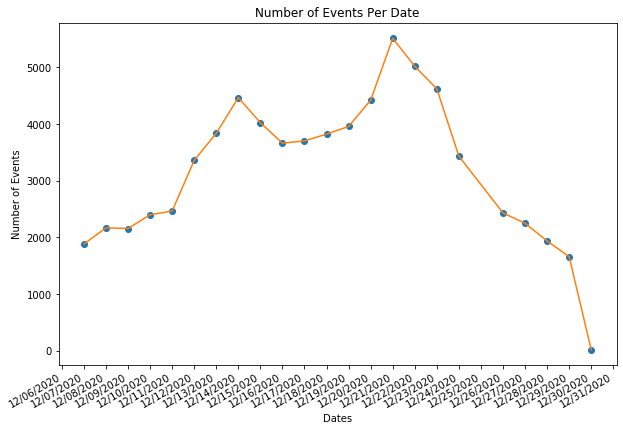

In [81]:
# line graph
plt.figure(figsize=(10,7))
dates = mpl.dates.date2num(events_per_day['date'])
plt.plot_date(dates, events_per_day['# of events'])
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mpl.dates.DayLocator())
plt.plot(dates, events_per_day['# of events'])
plt.gcf().autofmt_xdate()
plt.title('Number of Events Per Date')
plt.xlabel('Dates')
plt.ylabel('Number of Events');

As we mentioned above, there is absolutly no events on the 25. of December. The reason may be the holiday or rather some technical problem on this day which was not fixed in a short time because of the holiday.  

It seems, that on weekends the number of events is above average (two peeks on the graph), but we have not enough data: only two weekends after the test was launched and before the Christmas holidays began. 

It's absolutely logical, that after holidays the numbers tend to go down: there are no new users after the 2020-12-21; people were distracted by Christmas, many of them are spending holiday not at home; most of the gifts are already purchesed and so on. 

##### Step 2.6 Before the A/B test 

<a class="anchor" id="part26"></a> 

We didn't find something else we hadn't discussed earlier. 

#### Step 3. A/B Test Evaluation

<a class="anchor" id="part3"></a>

Actually we concidered the test's group conversion in the [step 2.3](#part23). 

The main conclusion we made is that the group B has not any significantly better figures. With other words, A/B test showed, that the new payment funnel does not bring any better performance. 

We have two different experiment groups. In such cases it is important to ensure that that the results from these groups are based on fair numbers. 

To do so, we want to check if there is a statistically significant difference between the groups. 

If we find that there is a significant difference, then the control groups have not be split up equally and any results we deduct will not accurately represent the customers.

We want to test the statistical significance of the difference in conversion between groups A and B. This can be done with Z-test. 

which returns the expected probability for observing a value (number of unique users per event in group A) less than or equal to a given value (number of unique users per event in group B).

To run a Z-tes, a few conditions should match: 

- Sample size is greater than 30. Otherwise, use a t test. (Is okay in our case)
- Data points should be independent from each other. (Is okay in our case)
- Data should be normally distributed. (We have to check it.)
- Data should be randomly selected from a population, where each item has an equal chance of being selected. (We are assuming, it is okay in our case)
- Sample sizes should be equal if at all possible. (The difference in sample size is around 3% in our case; we'll keep it in mind.)

So let's check if the data is normally distributed. 

In [82]:
eu_test_A.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
12,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test,2020-12-07,EU,Android
13,A92195E3CFB83DBD,2020-12-08 18:59:26,purchase,4.99,A,interface_eu_test,2020-12-07,EU,Android
14,A92195E3CFB83DBD,2020-12-11 19:16:25,purchase,4.99,A,interface_eu_test,2020-12-07,EU,Android
15,A92195E3CFB83DBD,2020-12-07 00:32:07,login,0.00,A,interface_eu_test,2020-12-07,EU,Android
16,A92195E3CFB83DBD,2020-12-08 18:59:26,login,0.00,A,interface_eu_test,2020-12-07,EU,Android


In [83]:
eu_test_A_mu = eu_test_A.details.mean()
eu_test_B_mu = eu_test_B.details.mean()
eu_test_A_sd = eu_test_A.details.std()
eu_test_B_sd = eu_test_B.details.std()

print('Group A µ', eu_test_A_mu)
print()
print('Group B µ',eu_test_B_mu)
print()
print('Group A SD', eu_test_A_sd)
print()
print('Group B SD',eu_test_B_sd)

Group A µ 3.653391409721287

Group B µ 3.35175780925192

Group A SD 29.59412441761708

Group B SD 28.32589388982594


The difference between standart deviation in groups is relatively small. We assume, we can perform a Z-test. 

We formulate our null Hypothesis(H0): There is no significant difference in conversion between groups A and B. 

Alternative Hypothesis(H1): There is a significant difference in conversion between groups A and B.

We use standart alpha level 0.05. 



In [84]:
eu_test['event_name']=eu_test['event_name'].astype('str')
eu_test['group']=eu_test['group'].astype('str')

In [85]:
exp_groups = eu_test.pivot_table(index='event_name', values='user_id', columns='group', aggfunc=lambda x: x.nunique()).reset_index()
group1 = 'A'
group2 = 'B'
alpha = 0.05

In [86]:
# find statistical significance for each group for each event
for event in exp_groups.event_name.unique():

    # define successes 
    successes1 = exp_groups[exp_groups.event_name == event][group1].iloc[0]
    successes2 = exp_groups[exp_groups.event_name == event][group2].iloc[0]

    # define trials
    trials1 = eu_test[eu_test.group == group1]['user_id'].nunique()
    trials2 = eu_test[eu_test.group == group2]['user_id'].nunique()

    # proportion for success in group 1
    p1 = successes1 / trials1

    # proportion for success in group 2
    p2 = successes2 / trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # define difference and z value
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # calculate distribution
    distr = stats.norm(0,1)

    # calculate p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p_value: ', p_value)
    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups ',group1,' and ', group2, '\n')
    else:
        print("Fail to Reject H0 for", event,'and groups ',group1,' and ', group2, '\n')

p_value:  0.3201520788748984
Fail to Reject H0 for login and groups  A  and  B 

p_value:  0.10323395997153062
Fail to Reject H0 for product_cart and groups  A  and  B 

p_value:  0.12244077100223438
Fail to Reject H0 for product_page and groups  A  and  B 

p_value:  0.021997971549269524
Reject H0 for purchase and groups  A  and  B 



For the events login, product page and product cart, the p_value is greater than the defined alpha level of 0.05 which means that we cannot reject the null hypothesis. With other words, we can claim, there is a statistically significant difference between the two control groups for each event.

For the purchase event, the p_value is less than the defined alpha level of 0.05 which means that we have to reject the null hypothesis. With other words, we can claim, there is not a statistically significant difference between the two control groups for the purchase event.

#### Step 4. Overall conclusion

<a class="anchor" id="conclusion"></a>

The goal of our project was to determine whether the introduction of an improved recommendation system impacts conversion of users of an online store. It was expected that with this new system, users will show a 10% increase in conversion.

We found out during EDA, it was found that 17% of users in group A (the control group) converted (made a purchase) while 16.4% of users in group B (the improved recommendation systerm) converted. This data suggests that the improved recommendation system did not lead to an increase in conversion but in fact led to a slight decrease in conversion.

From A/B testing, it was found that there was a statistically significant difference between groups A and B for login, product page view and product cart view. The recommendation system worked for these events. However, for the purchase event, it was determined that there is not a statistically significant difference between the two control groups for the purchase event.

As a result, the analysis of the data suggests not to apply the improved recommendation system to the international online store. Perhaps the store should stick with its current model or enhance the recommendation system.